In [9]:
PROJECT_ID = "vertexaiproject-454121"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

REGION = 'us-central1'

# Model Training
VAR_TARGET = 'Class'

Updated property [core/project].


In [10]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertexaiproject-454121'

packages:

In [11]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

In [12]:
bq = bigquery.Client()
aiplatform.init(location = REGION)

In [13]:
query = f"""
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection` LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,8748.0,-1.070416,0.304517,2.777064,2.154061,0.254450,-0.448529,-0.398691,0.144672,1.070900,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,27074.0,1.165628,0.423671,0.887635,2.740163,-0.338578,-0.142846,-0.055628,-0.015325,-0.213621,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,28292.0,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,28488.0,1.070316,0.079499,1.471856,2.863786,-0.637887,0.858159,-0.687478,0.344146,0.459561,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,31392.0,-3.680953,-4.183581,2.642743,4.263802,4.643286,-0.225053,-3.733637,1.273037,0.015661,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


In [14]:
query = f"""
SELECT Class, COUNT(*) as count
FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
GROUP BY Class
ORDER BY Class;

"""
bq.query(query = query).to_dataframe()

,Class,count
0,0,284315
1,1,492


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign `TRAIN`, `EVAL`, and `TEST` data splits.
    - the `CASE` statement maps the validation data to `EVAL` as expected by hyperparameter tuning (rather than `VALIDATE`)
    - note that this is different behavior for `data_split_col` with hyperparameter tuning than without hyperparameter tuning
    - hyperparameter suggestions are based on the metric calculated with the evaluation data at each intermediate step
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

**Hyperparameter Tuning**

The [following options](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#create_model_syntax) are added to the model training code for BQML to guide the hyperparameter tuning of `L1` and `L2` regularization:

```SQL
l1_reg = HPARAM_RANGE(0, 1000),
l2_reg = HPARAM_RANGE(0, 1000),
hparam_tuning_algorithm = 'VIZIER_DEFAULT',
hparam_tuning_objectives = ['ROC_AUC'],
num_trials = 20,
max_parallel_trials = 2
```

This instructs BQML to use the Vertex AI Vizier service to find values of `l1_reg` and `l2_reg` that optimize 'roc_auc' by doing 4 trials at a time until 20 trials have been completed.


In [21]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.dataset_name`;

CREATE OR REPLACE MODEL `{PROJECT_ID}.dataset_name.model_name`
TRANSFORM(
    * EXCEPT(Amount),
    SAFE.LOG(Amount) AS log_amount
)

OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'Time',
        data_split_method = 'seq',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 20,
        max_parallel_trials = 2
    ) AS
    
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
"""
print(query)


CREATE SCHEMA IF NOT EXISTS `vertexaiproject-454121.dataset_name`;

CREATE OR REPLACE MODEL `vertexaiproject-454121.dataset_name.model_name`
TRANSFORM(
    * EXCEPT(Amount),
    SAFE.LOG(Amount) AS log_amount
)

OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['Class'],
        enable_global_explain = TRUE,
        data_split_col = 'Time',
        data_split_method = 'seq',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 20,
        max_parallel_trials = 2
    ) AS
    
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`



In [22]:
job = bq.query(query = query)
job.result()

In [23]:
query = f"""
SELECT * FROM ML.EVALUATE(MODEL `{PROJECT_ID}.dataset_name.model_name`)
"""
bq.query(query = query).to_dataframe()

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.031148,0.863636,0.979173,0.060127,0.117812,0.980979
1,2,0.031148,0.863636,0.979173,0.060127,0.117812,0.980979
2,3,0.031148,0.863636,0.979173,0.060127,0.117812,0.980979
3,4,0.031148,0.863636,0.979173,0.060127,0.117812,0.980979
4,5,0.031148,0.863636,0.979173,0.060127,0.117811,0.980979
5,6,0.031250,0.863636,0.979243,0.060317,0.117619,0.980933
6,7,0.027508,0.772727,0.978752,0.053125,0.128735,0.967234
7,8,0.006193,0.863636,0.892991,0.012298,0.568281,0.913119
8,9,0.027508,0.772727,0.978752,0.053125,0.128736,0.967234
9,10,0.031148,0.863636,0.979173,0.060127,0.117809,0.980979


In [24]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [25]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{PROJECT_ID}.dataset_name.model_name`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,V20,-28.009635,39.420904,0.009948,-0.048657,0.779107,<NA>,0,<NA>
1,V27,-22.565679,12.152401,0.000218,0.003504,0.400490,<NA>,0,<NA>
2,V5,-42.147898,34.801666,-0.063886,-0.124240,1.373119,<NA>,0,<NA>
3,V4,-5.683171,16.875344,0.043783,0.034305,1.411271,<NA>,0,<NA>
4,V24,-2.836627,4.022866,0.001098,0.048409,0.605979,<NA>,0,<NA>
5,Amount,0.000000,19656.530000,90.835613,23.000000,250.529784,<NA>,0,<NA>
6,V9,-13.434066,15.594995,0.002210,-0.064195,1.123461,<NA>,0,<NA>
7,V3,-33.680984,9.382558,0.182743,0.370863,1.490413,<NA>,0,<NA>
8,V12,-18.683715,7.848392,-0.045040,0.108923,1.055958,<NA>,0,<NA>
9,V14,-19.214325,10.526766,0.032944,0.057199,0.965688,<NA>,0,<NA>


Retrieve the trial info for the hyperparameter tuning trials with [ML.TRIAL_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-trial-info):

In [26]:
trials = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRIAL_INFO(MODEL `{PROJECT_ID}.dataset_name.model_name`)
        """
).to_dataframe()
trials

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1e-14}",{'roc_auc': 0.9876993006993007},0.118310,0.121671,SUCCEEDED,None,False
1,2,"{'l1_reg': 5.448187430710835e-11, 'l2_reg': 5....",{'roc_auc': 0.9876993006993007},0.118310,0.121671,SUCCEEDED,None,False
2,3,"{'l1_reg': 1e-14, 'l2_reg': 6.457980845767538e...",{'roc_auc': 0.9876993006993007},0.118310,0.121671,SUCCEEDED,None,False
3,4,"{'l1_reg': 1.4307188333773798e-06, 'l2_reg': 1...",{'roc_auc': 0.9876993006993007},0.118310,0.121671,SUCCEEDED,None,False
4,5,"{'l1_reg': 0.08158595196802981, 'l2_reg': 1.56...",{'roc_auc': 0.9876993006993007},0.118310,0.121670,SUCCEEDED,None,False
5,6,"{'l1_reg': 0.17943596228391423, 'l2_reg': 0.17...",{'roc_auc': 0.9876993006993007},0.118175,0.121473,SUCCEEDED,None,False
6,7,"{'l1_reg': 1000.0, 'l2_reg': 1e-14}",{'roc_auc': 0.9874765234765235},0.109700,0.116954,SUCCEEDED,None,False
7,8,"{'l1_reg': 2.978685308994847e-07, 'l2_reg': 10...",{'roc_auc': 0.9061778221778222},0.536178,0.530026,SUCCEEDED,None,False
8,9,"{'l1_reg': 1000.0, 'l2_reg': 5.662878627879470...",{'roc_auc': 0.9874765234765235},0.109701,0.116955,SUCCEEDED,None,False
9,10,"{'l1_reg': 0.35687456109496984, 'l2_reg': 8.75...",{'roc_auc': 0.9876993006993007},0.118308,0.121666,SUCCEEDED,None,False


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [27]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{PROJECT_ID}.dataset_name.model_name`,(
    SELECT *
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    )
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,20,0,278935,5380
1,20,1,45,447


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [28]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{PROJECT_ID}.dataset_name.model_name`,(
    SELECT *
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    )
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,20,1.000000,0.030488,0.000000,15,0,284315,477
1,20,0.673836,0.886179,0.008712,436,2477,281838,56
2,20,0.506026,0.908537,0.018437,447,5242,279073,45
3,20,0.412382,0.916667,0.028648,451,8145,276170,41
4,20,0.351546,0.926829,0.038960,456,11077,273238,36


---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [29]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{PROJECT_ID}.dataset_name.model_name`,(
    SELECT *
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    ), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [30]:
explain.head()

,trial_id,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,20,0,0.827952,"[{'feature': 'V12', 'attribution': 1.432409723...",-2.709823,-1.571178,0.0,8748.0,-1.070416,0.304517,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,20,0,0.816305,"[{'feature': 'V4', 'attribution': 1.7183953179...",-2.709823,-1.491509,0.0,27074.0,1.165628,0.423671,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,20,0,0.868312,"[{'feature': 'V4', 'attribution': 1.6712320177...",-2.709823,-1.886113,0.0,28292.0,1.050879,0.053408,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,20,0,0.781104,"[{'feature': 'V4', 'attribution': 1.7971800057...",-2.709823,-1.272114,0.0,28488.0,1.070316,0.079499,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,20,0,0.619998,"[{'feature': 'V4', 'attribution': 2.6894062773...",-2.709823,-0.489538,0.0,31392.0,-3.680953,-4.183581,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


Create a plot of feature attributions for a single prediction:

In [31]:
explanation = explain.iloc[0]['top_feature_attributions']

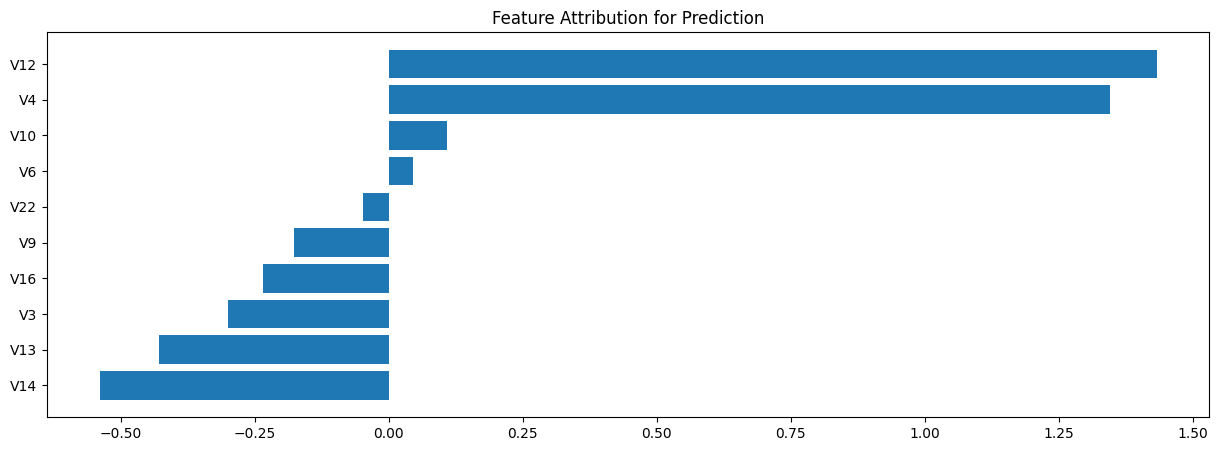

In [32]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [33]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{PROJECT_ID}.dataset_name.model_name`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [34]:
gexplain.head()

,trial_id,feature,attribution
0,20,V4,0.685358
1,20,V14,0.466199
2,20,V12,0.363206
3,20,V10,0.263704
4,20,V16,0.224919


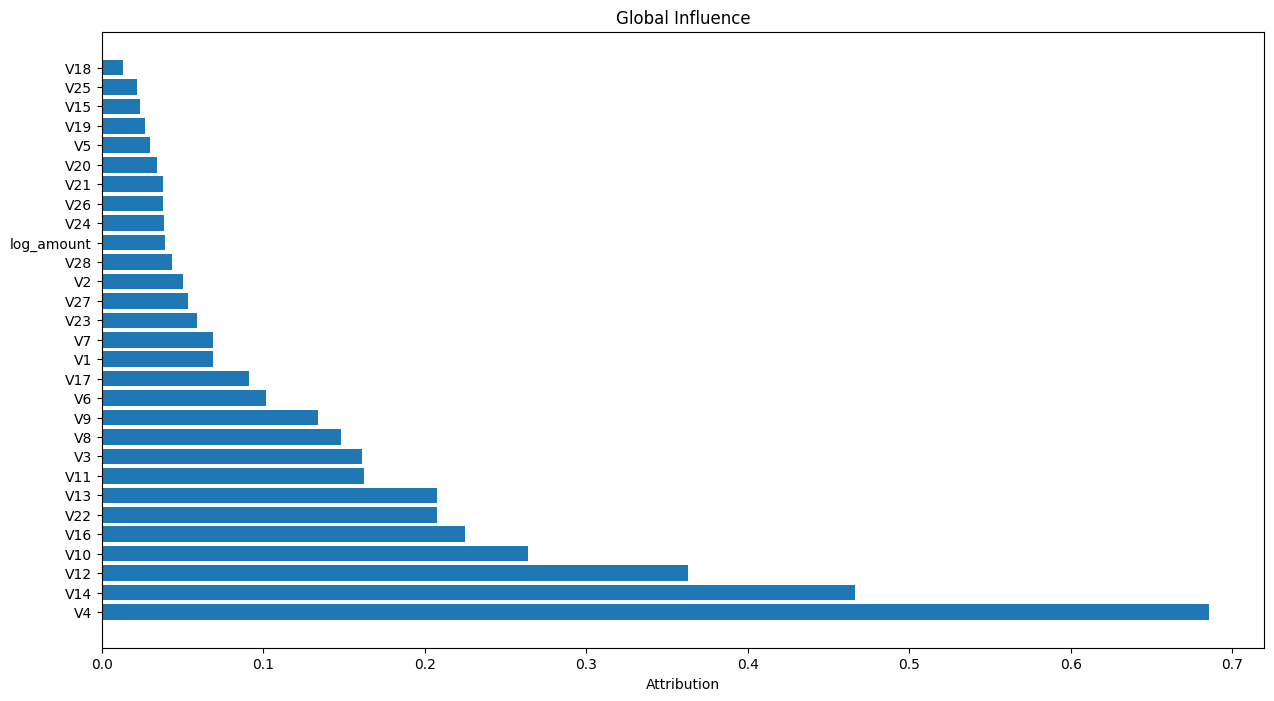

In [35]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

The training options for creating the model include registering the model the Vertex AI Automatically.  This makes deploying the model to a [Vertex AI Endpoint for online serving](https://cloud.google.com/vertex-ai/docs/general/deployment) very easy.

### Vertex AI Model Registry - Get Model

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model using the [Vertex AI Python Client](../Tips/aiplatform_notes.md).

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [ ]:
vertex_model = aiplatform.Model(model_name = f'bqml_{SERIES}_{EXPERIMENT}')
vertex_model.resource_name

In [ ]:
# note: this is blank since the model is managed by BQML and container is pre-specified
vertex_model.uri 

In [ ]:
vertex_model.gca_resource

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [ ]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

In [ ]:
endpoint.display_name

In [ ]:
endpoint.traffic_split

In [ ]:
deployed_models = endpoint.list_models()
for d in deployed_models: print(d.display_name)

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

In [ ]:
endpoint.deploy(
    model = vertex_model,
    deployed_model_display_name = vertex_model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_parameters = aiplatform.explain.ExplanationParameters(), # supress the explanation specs from BQML during deployment
    explanation_metadata = aiplatform.explain.ExplanationMetadata()
)

---
# DEBUGGING

ERROR related to explanationspec from BQML registering model in Vertex AI Model Registry.  View the spec with `vertex_model.gca_resource`

---

In [ ]:
endpoint.list_models()

### Remove Deployed Models without Traffic

In [ ]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

In [ ]:
endpoint.traffic_split

In [ ]:
#endpoint.list_models()

---
## Predictions With Vertex AI Endpoint

### Retrieve Records For Prediction

In [ ]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

Shape as instances: dictionaries of key:value pairs for only features used in model

In [ ]:
newobs = pred.to_dict(orient = 'records')

In [ ]:
newobs[0]

### Get Predictions: Python Client

In [ ]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

In [ ]:
prediction.predictions[0]

In [ ]:
np.argmax(prediction.predictions[0])

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:predict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_predict)

Prepare request:

In [ ]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [ ]:
prediction = !curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

Format raw prediction response using JSON:

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict)

Prepare request:

In [ ]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [ ]:
prediction = !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json
prediction

---
## Export Model

The model created in BigQuery ML can be exported to their native model types save files.  This process saves the model artifacts in GCS where they can be use anywhere they are needed.  For instance, they could be imported into the Vertex AI Model Registry for use in online and batch serving - however, this process is automated with the training options use above.

### Export the BigQuery Model


The models trained in BQML can be exported from BigQuery to GCS:

Reference:
- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [ ]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [ ]:
(export.ended - export.started).total_seconds()

In [ ]:
listing = !gsutil ls gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model
listing

In [ ]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

### Detect The Model Types Framework

In [ ]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(list(set(filetypes))) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

In [ ]:
list(set(filetypes))

---
## Remove Resources

The following cells have commented out statements that can be used to remove resources created by this notebook.  Other notebooks in the repository will reusue the same endpoint so it may be desired to not remove the endpoint if you plan to run additional notebooks.  Otherwise, please removed the endpoint to prevent ongoing cost from hosting the models on Vertex AI Endpoints.

Similarly, if you want to remove the model from BQML to prevent the minimal storage cost it will automatically be removed from Vertex AI Model Registry as well.

In [ ]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
#endpoint.delete(force = True)

In [ ]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
#bq.delete_model(model)